In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import numpy as np
import re
import time
import datetime
import matplotlib.dates as mdates
from math import ceil

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

#### Statistical analysis

In [2]:
def extract_split_data(data):    
    content = re.findall("\[(.*?)\]", data)
   
    values = []
    for c in content[0].split(","):
        c = (c.strip()[1:-1])
        if len(c)>21:  
            x, y = c.split("#")
            values.append(int(x))
           
    return values

In [3]:
def gsr_analysis(span, plotting = True):
    sessionCount = 0
    veryBeginning = []
    nearEnd = []
    duringGame = []

    size = span//2 + 1 # half

    for url in glob.glob("/Users/xueguoliang/Desktop/Data_v2/*.csv"):

        player = pd.read_csv(url, delimiter=";")

        for session in player['GSR']:       
            rate = extract_split_data(session)

            if len(rate)>span:
                sessionCount += 1
                veryBeginning.append(rate[0:span])
                nearEnd.append(rate[-1-span:-1])
                if len(rate)%2 == 0:
                    duringGame.append(rate[len(rate)//2-size+1:len(rate)//2+size-1])
                else:
                    duringGame.append(rate[len(rate)//2-size+1:len(rate)//2+size-1])


    print("We have collected {} games.".format(sessionCount))
    print("The size of GSR sample is {}.".format(span))
    
    if(plotting):
        #plot
        fig, ax = plt.subplots(3, 2, figsize=(15,15))
        labels = ["Postive", "Negative"]

        ########################################## Begin ##################################################

        std_begin = []
        slope_begin = []
        for item in veryBeginning:
            slope_begin.append((item[-1]-item[0])/(len(item)-1))
            std_begin.append(round(np.std(item), 2))

        begin_pos = sum([1 for x in slope_begin if x > 0])
        begin_nag = sum([1 for x in slope_begin if x < 0])
        dict_begin = {1:begin_pos, 2:begin_nag}

        ax[0][0].set_title("Distribution of STD for Beginning of game")
        ax[0][0].hist(std_begin, bins=50, range=(min(std_begin), max(std_begin)))
        #ax[0][0].set_xlim([0,10])
        #ax[0][0].set_ylim([0,400])

        ax[0][1].set_title("Distribution of Slope(+,-) for Beginning of game")
        ax[0][1].bar(range(len(dict_begin)), dict_begin.values(), color='g')

        ax[0][1].set_xticklabels(("","","Positive","","","", "Negative"))

        ########################################## During #################################################

        std_during = []
        slope_during = []    
        for item in duringGame:
            slope_during.append((item[-1]-item[0])/(len(item)-1))
            std_during.append(round(np.std(item), 2))

        during_pos = sum([1 for x in slope_during if x > 0])
        during_nag = sum([1 for x in slope_during if x < 0])
        dict_during = {1:during_pos, 2:during_nag}

        ax[1][0].set_title("Distribution of STD for During of game")
        ax[1][0].hist(std_during, bins=50, range=(min(std_during), max(std_during)))
        #ax[1][0].set_xlim([0,300])

        ax[1][1].set_title("Distribution of Slope(+,-) for During of game")
        ax[1][1].bar(list(dict_during.keys()), dict_during.values(), color='g')

        ax[1][1].set_xticklabels(("","","Positive","","","", "Negative"))


        ########################################## End ###################################################

        std_end = []
        slope_end = []
        for item in nearEnd:
            slope_end.append((item[-1]-item[0])/(len(item)-1))
            std_end.append(round(np.std(item), 2))

        end_pos = sum([1 for x in slope_end if x > 0])
        end_nag = sum([1 for x in slope_end if x < 0])
        dict_end = {1:end_pos, 2:end_nag}

        ax[2][0].set_title("Distribution of STD for End of game")
        ax[2][0].hist(std_end, bins=50, range=(min(std_end), max(std_end)))
        #ax[2][0].set_xlim([0,100])

        ax[2][1].set_title("Distribution of Slope(+,-) for End of game")
        ax[2][1].bar(list(dict_end.keys()), dict_end.values(), color='g')

        ax[2][1].set_xticklabels(("","","Positive","","","", "Negative"))


        plt.show()   
    
    return veryBeginning, duringGame, nearEnd

We have collected 570 games.
The size of GSR sample is 20.


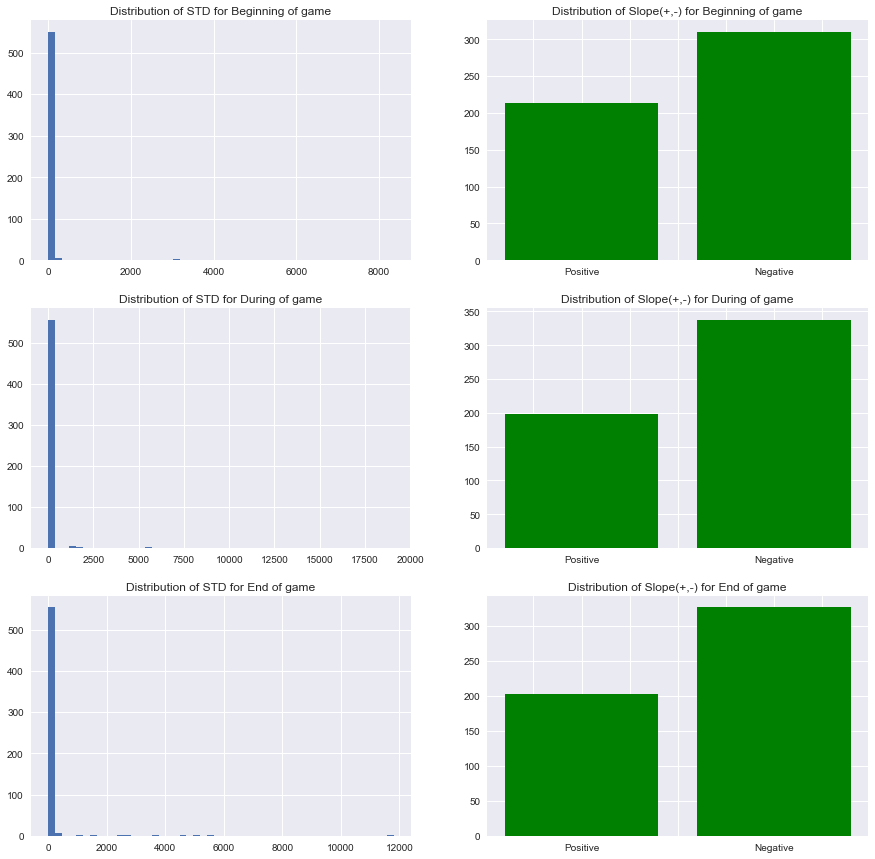

We have collected 382 games.
The size of GSR sample is 50.


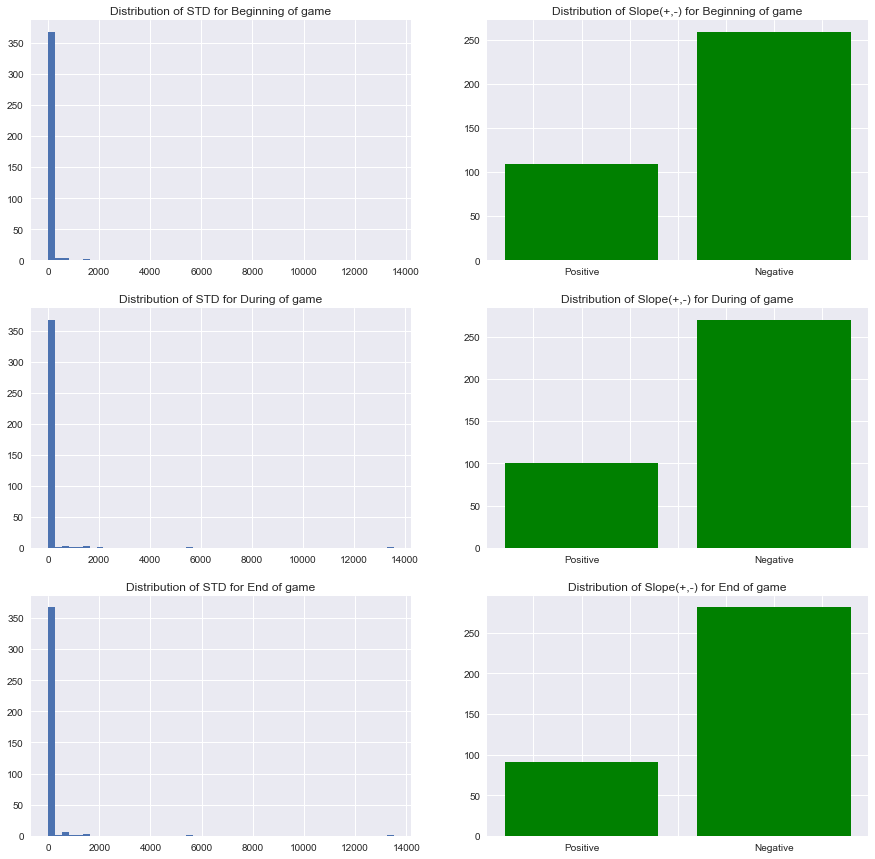

We have collected 171 games.
The size of GSR sample is 100.


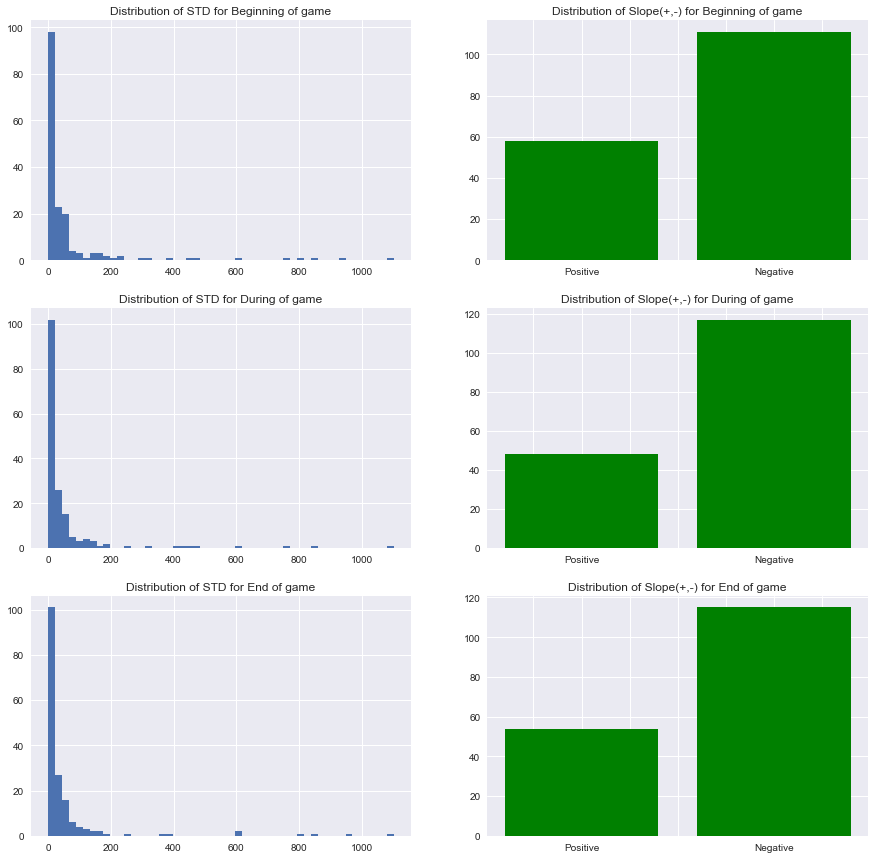

We have collected 95 games.
The size of GSR sample is 150.


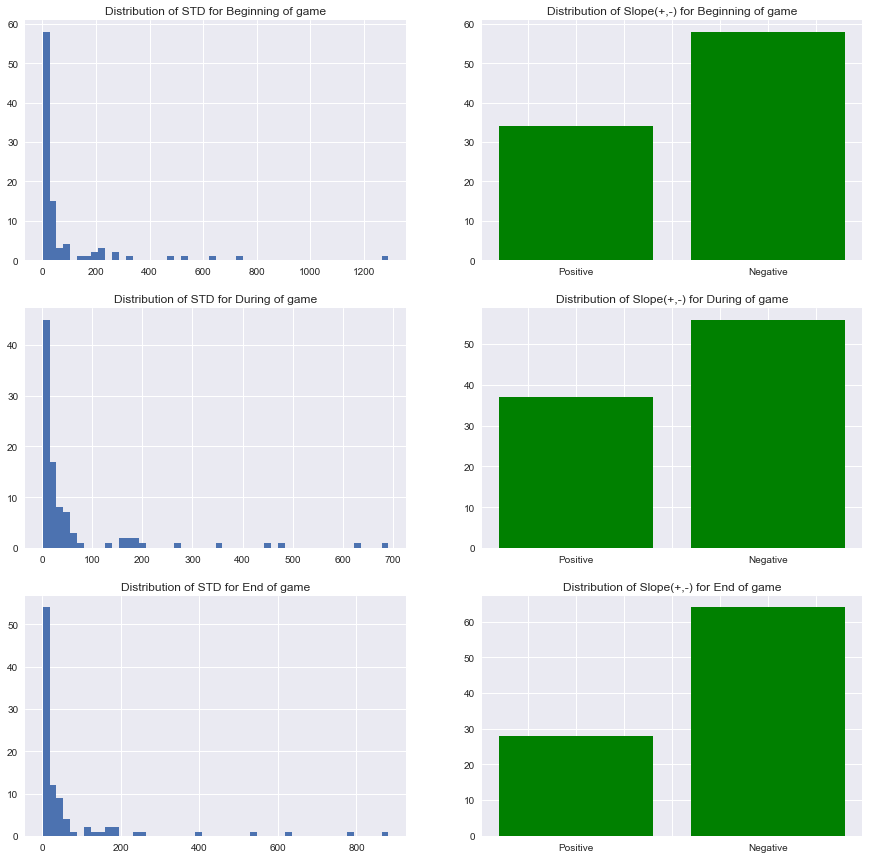

We have collected 57 games.
The size of GSR sample is 250.


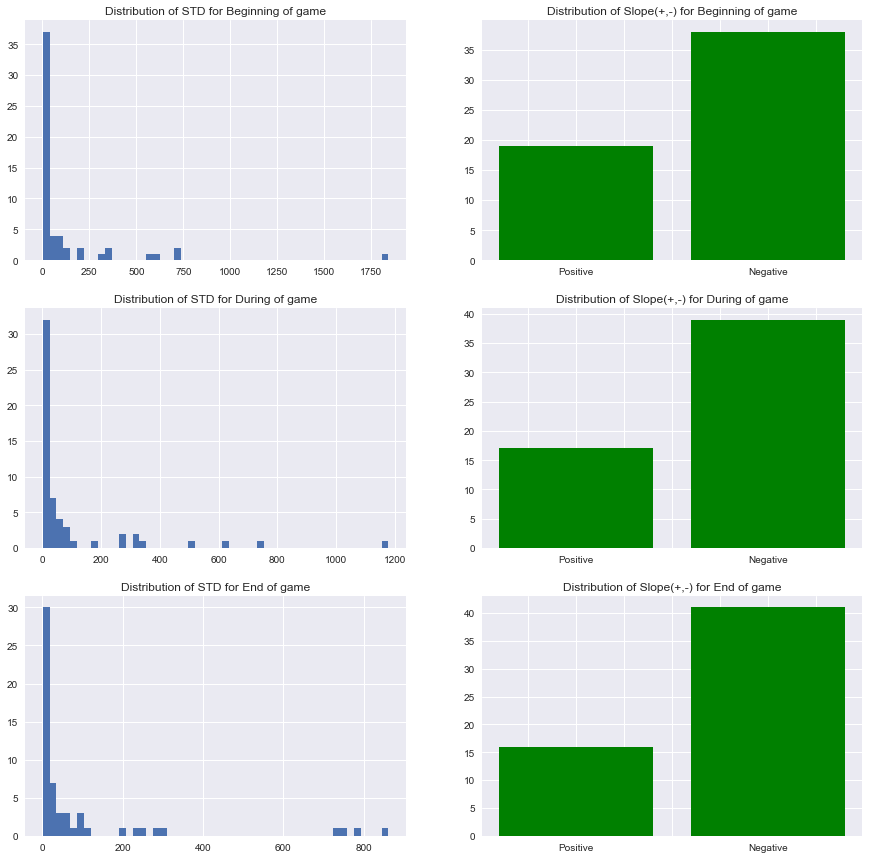

In [4]:
test = [20, 50, 100, 150, 250]

for t in test:
    gsr_analysis(t)

#### Decision Tree / SVM Model 

In [5]:
begin, during, end = gsr_analysis(20, False)

We have collected 570 games.
The size of GSR sample is 20.


In [6]:
dict_begin = {}
label_begin = []
var_begin = []
max_begin = []
min_begin = []
first_quartile_begin = []
third_quartile_begin = []
average_begin = []
median_begin = []

for b in begin:   
    label_begin.append(int(0)) 
    var_begin.append(np.var(b))
    max_begin.append(np.max(b))
    min_begin.append(np.min(b))
    first_quartile_begin.append(np.percentile(b, 25))
    third_quartile_begin.append(np.percentile(b, 75))
    average_begin.append(np.average(b))
    median_begin.append(np.median(b))
    
dict_begin["label"] = label_begin
dict_begin["variance"] = var_begin
dict_begin["max"] = max_begin
dict_begin["min"] = min_begin
dict_begin["first_quartile"] = first_quartile_begin
dict_begin["third_quartile"] = third_quartile_begin
dict_begin["average"] = average_begin
dict_begin["median"] = median_begin

f1 = pd.DataFrame(dict_begin)
print(f1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 8 columns):
average           570 non-null float64
first_quartile    570 non-null float64
label             570 non-null int64
max               570 non-null int64
median            570 non-null float64
min               570 non-null int64
third_quartile    570 non-null float64
variance          570 non-null float64
dtypes: float64(5), int64(3)
memory usage: 35.7 KB
None


In [7]:
dict_during = {}
label_during = []
var_during = []
max_during = []
min_during = []
first_quartile_during = []
third_quartile_during = []
average_during = []
median_during = []

for b in during:   
    label_during.append(int(1)) 
    var_during.append(np.var(b))
    max_during.append(np.max(b))
    min_during.append(np.min(b))
    first_quartile_during.append(np.percentile(b, 25))
    third_quartile_during.append(np.percentile(b, 75))
    average_during.append(np.average(b))
    median_during.append(np.median(b))

dict_during["label"] = label_during
dict_during["variance"] = var_during
dict_during["max"] = max_during
dict_during["min"] = min_during
dict_during["first_quartile"] = first_quartile_during
dict_during["third_quartile"] = third_quartile_during
dict_during["average"] = average_during
dict_during["median"] = median_during


f2 = pd.DataFrame(dict_during)
print(f2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 8 columns):
average           570 non-null float64
first_quartile    570 non-null float64
label             570 non-null int64
max               570 non-null int64
median            570 non-null float64
min               570 non-null int64
third_quartile    570 non-null float64
variance          570 non-null float64
dtypes: float64(5), int64(3)
memory usage: 35.7 KB
None


In [8]:
dict_end = {}
label_end = []
var_end = []
max_end = []
min_end = []
first_quartile_end = []
third_quartile_end = []
average_end = []
median_end = []

for b in end:   
    label_end.append(int(2)) 
    var_end.append(np.var(b))
    max_end.append(np.max(b))
    min_end.append(np.min(b))
    first_quartile_end.append(np.percentile(b, 25))
    third_quartile_end.append(np.percentile(b, 75))
    average_end.append(np.average(b))
    median_end.append(np.median(b))

dict_end["label"] = label_end
dict_end["variance"] = var_end
dict_end["max"] = max_end
dict_end["min"] = min_end
dict_end["first_quartile"] = first_quartile_end
dict_end["third_quartile"] = third_quartile_end
dict_end["average"] = average_end
dict_end["median"] = median_end

f3 = pd.DataFrame(dict_end)

In [9]:
final_data = pd.concat([f1,f2,f3], ignore_index=True)

In [10]:
epochs = 10

In [11]:
for i in range(epochs):
    final_data = final_data.sample(frac=1)
    train, test = train_test_split(final_data, test_size = 0.2)
    y = train["label"]
    X = train.drop("label", axis=1)
    #X = train[['average', 'max', 'median', 'min','variance']]
    tree_clf = DecisionTreeClassifier(random_state=0, max_depth=5)
    tree_clf.fit(X, y)
    print("the score for each epoch: {}".format(tree_clf.score(X,y)))

the score for each epoch: 0.3713450292397661
the score for each epoch: 0.40862573099415206
the score for each epoch: 0.38377192982456143
the score for each epoch: 0.37792397660818716
the score for each epoch: 0.3991228070175439
the score for each epoch: 0.3830409356725146
the score for each epoch: 0.39035087719298245
the score for each epoch: 0.3969298245614035
the score for each epoch: 0.3888888888888889
the score for each epoch: 0.37719298245614036


In [12]:
print(X.columns)
tree_clf.feature_importances_

Index(['average', 'first_quartile', 'max', 'median', 'min', 'third_quartile',
       'variance'],
      dtype='object')


array([ 0.01443369,  0.03464085,  0.        ,  0.25167496,  0.04189311,
        0.05658005,  0.60077735])

In [13]:
export_graphviz(
    tree_clf,
    out_file= "bird_tree.dot",
    feature_names=X.columns,
    class_names=["begin","during","end"],
    rounded=True,
    filled=True
)

In [14]:
from subprocess import check_call
check_call(['dot','-Tpng','bird_tree.dot','-o','bird_tree.png'])

0

In [15]:
y_test = test["label"]
X_test = test.drop("label", axis=1)
tree_clf.score(X_test, y_test)

0.34210526315789475